# HOMEWORK 06

# BUILDING MODEL

In [ ]:
!pip install tensorflow_datasets tqdm

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Prepare Dataset and Visualisation

In [6]:
# Load CIFAR10 dataset
def load_data():
    (train_ds, test_ds), ds_info = tfds.load('cifar10', 
                                             split=['train', 'test'], 
                                             as_supervised=True, 
                                             with_info=True)
    
    return (train_ds, test_ds), ds_info

In [7]:
# Check Dataset Information
(train_ds,test_ds), ds_info = load_data()

2022-12-08 17:14:12.185734: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3NXG9D/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3NXG9D/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


2022-12-08 17:16:31.727121: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


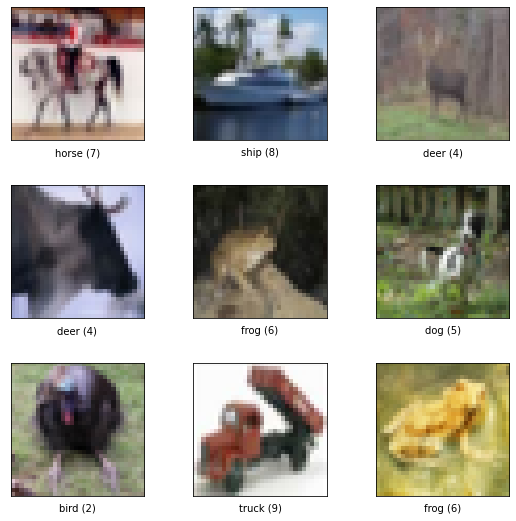

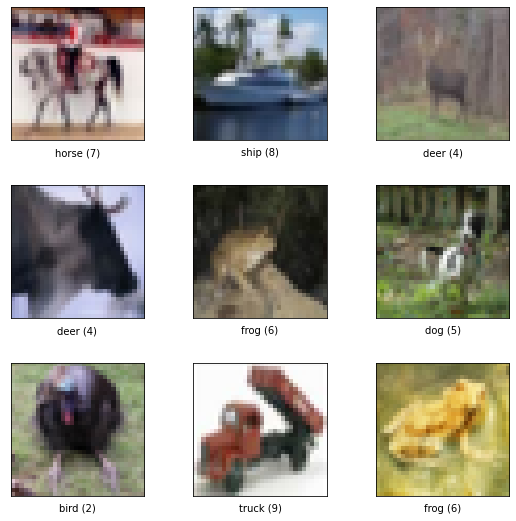

In [8]:
# Visualising dataset
tfds.show_examples(train_ds, ds_info)

**About dataset**:
- 32x32 colour images
- training: 50,000
- test: 10,000
- label: 10 categories
- datatype: tf.uint8

In [9]:
def preprocess(data):
  # convert (uint8 to float32)
  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
  # normalisation ( [0, 255] to [-1, 1] )
  data = data.map(lambda img, target: ((img/128.)-1., target))
  # create one-hot targets (10 classes)
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  
  # caching transformation on dataset 
  data = data.cache()
  
  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(32)
  data = data.prefetch(tf.data.AUTOTUNE)
  
  #return preprocessed dataset
  return data

In [10]:
# Apply function prepare_data to dataset
train_ds = train_ds.apply(preprocess)
test_ds = test_ds.apply(preprocess)

## Training Network

In [ ]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range (epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0,leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in test_ds:
            model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")
    
    model.save_weights(save_path)

## The Resnet Model from hw05

In [11]:
# Class: LAYER on DenseNet
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    # not taking it as output but concatinating them
    # then will be stacking all the way to the next layer
    x = tf.concat((x,c), axis=-1) 
    return x

# Class: BLOCK on DenseNet
class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super().__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# Class: NETWORK of DenseNet
class CNN(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    # num_filters = 24 / n layers = 4
    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()
    # 16x16 resolution (from original 32 x 32)
    self.denseblock2 = DenselyConnectedCNNBlock(48,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()
    # 8x8 resolution (from input 16 x 16)
    self.denseblock3 = DenselyConnectedCNNBlock(96,4)
    
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

    self.optimizer = optimizer
    self.loss_function = loss_function

    self.metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Mean(name="loss")
    ]

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

  # reset all metrics
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

  def train_step(self, data):
      image, label = data

      with tf.GradientTape() as tape:
          prediction = self(image, training = True)
          loss = self.loss_function(label, prediction)

      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)


  def test_step(self, data):
      image, label = data
      prediction = self(image, training = False)
      loss = self.loss_function(label, prediction)
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)

(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'resnet_no_optimisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = 10

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimizer}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

## Optimisation 1
Write down how it works and why you are specifically using it (And perhaps why you’re using it over another technique).

## Optimisation 2
Write down how it works and why you are specifically using it (And perhaps why you’re using it over another technique).

## Optimisation 3
Write down how it works and why you are specifically using it (And perhaps why you’re using it over another technique).

## Optimisation 4
Write down how it works and why you are specifically using it (And perhaps why you’re using it over another technique).

## Optimisation 5
Write down how it works and why you are specifically using it (And perhaps why you’re using it over another technique).